# Bareinboim Inequalities for MIMIC

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.stats import rankdata
import os
import glob
import re

exportdir='/data/localhost/taufiq/export-dir/'

In [2]:
import logging
logging.basicConfig(filename='bb-bounds.log', level=logging.INFO)

In [3]:
nra = 5
nr_reps = 1
col_bins_num = 5

In [4]:
MIMICtable = pd.read_csv(exportdir + '/MIMIC-1hourly-length-5.csv')
MIMICtable = MIMICtable.sort_values(by=['icustay_id', 'bloc'], ignore_index=True)
MIMICtable.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,mechvent,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance
0,1,3,7.245400e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.663900,599.999991,0.0,0.0,6267.0,0.0,9490.0,4705.0,-3223.0
1,2,3,7.245403e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.672340,339.999995,0.0,0.0,6267.0,10.0,14095.0,4605.0,-7818.0
2,3,3,7.245407e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.649789,339.999995,0.0,0.0,6277.0,20.0,18540.0,4445.0,-12243.0
3,4,3,7.245410e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.634454,339.999995,0.0,0.0,6297.0,20.0,22845.0,4305.0,-16528.0
4,5,3,7.245414e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.645714,497.499993,0.0,0.0,6317.0,20.0,27050.0,4205.0,-20713.0


In [5]:
age_ranked = rankdata(MIMICtable['age'])/len(MIMICtable)
age_bins = np.floor((age_ranked + 0.2499999999)*4)
median_ages = [MIMICtable.loc[age_bins==1, 'age'].median(), MIMICtable.loc[age_bins==2, 'age'].median(), MIMICtable.loc[age_bins==3, 'age'].median(), MIMICtable.loc[age_bins==4, 'age'].median()]
MIMICtable = MIMICtable.rename(columns={"age": "age_raw"})
MIMICtable['age'] = age_bins

In [6]:
os.chdir("/data/localhost/taufiq/biogears-data-5step/")
extension = '.csv'
all_filenames = [i for i in glob.glob('*{}'.format(extension))]
biogears_data = pd.DataFrame()
for f in tqdm(all_filenames):
    if os.path.getsize(f) > 0:
        df = pd.read_csv(f)
        m = re.search('SimulateMIMIC_(.+?)_.csv', f)
        if m:
            icustay_id = m.group(1)
            df['icustay_id'] = int(icustay_id)
        biogears_data = biogears_data.append(df, ignore_index=True)
times = [600.02, 3600.02, 7200.02, 10800.02, 14400.02]
biogears_data = biogears_data[biogears_data['Time(s)'].isin(times)].reset_index(drop=True)
biogears_data.loc['icustay_id'] = biogears_data['icustay_id'].astype(int)

100%|██████████| 4993/4993 [01:05<00:00, 75.93it/s] 


In [7]:
icustayids = []
for icustay_id in biogears_data['icustay_id'].unique():
    if (biogears_data['icustay_id'] == icustay_id).sum() == 5:
        icustayids.append(icustay_id)
        
biogears_data = biogears_data[biogears_data['icustay_id'].isin(icustayids)].reset_index(drop=True)
biogears_data = biogears_data.sort_values(by=['icustay_id', 'Time(s)'], ignore_index=True)
biogears_data['bloc'] = np.arange(len(biogears_data))%5 + 1
len(biogears_data)

24965

In [8]:
column_mappings = {
    'Albumin-BloodConcentration(ug/mL)': 'Albumin',
    'ArterialCarbonDioxidePressure(mmHg)': 'paCO2',
    'ArterialOxygenPressure(mmHg)': 'paO2',
    'Bicarbonate-BloodConcentration(ug/mL)': 'HCO3',
    'ArterialBloodPH': 'Arterial_pH',
    'Calcium-BloodConcentration(ug/mL)': 'Calcium',
    'Chloride-BloodConcentration(ug/mL)': 'Chloride',
    'Creatinine-BloodConcentration(ug/mL)': 'Creatinine',
    'DiastolicArterialPressure(mmHg)': 'DiaBP',
    'Glucose-BloodConcentration(ug/mL)': 'Glucose',
    'Lactate-BloodConcentration(ug/mL)': 'Arterial_lactate',
    'MeanArterialPressure(mmHg)': 'MeanBP',
    'Potassium-BloodConcentration(ug/mL)': 'Potassium',
    'RespirationRate(1/min)': 'RR',
    'SkinTemperature(degC)': 'Temp_C',
    'Sodium-BloodConcentration(ug/mL)': 'Sodium',
    'SystolicArterialPressure(mmHg)': 'SysBP',
    'WhiteBloodCellCount(ct/uL)': 'WBC_count',
    'HeartRate(1/min)': 'HR'
}

biogears_rename = {}

for k, v in column_mappings.items():
    biogears_rename.update({k: f"{v}"})

biogears_data = biogears_data.rename(columns=biogears_rename)
biogears_data = biogears_data.merge(MIMICtable[['gender', 'age', 'Weight_kg', 'icustay_id', 'bloc']], left_on=['icustay_id', 'bloc'], right_on=['icustay_id', 'bloc'])

biogears_data.head()

,Time(s),HR,MeanBP,SysBP,DiaBP,CardiacOutput(mL/min),HemoglobinContent(g),CentralVenousPressure(mmHg),Hematocrit,Arterial_pH,...,Potassium,Chloride,Calcium,Magnesium-BloodConcentration,Albumin,icustay_id,bloc,gender,age,Weight_kg
0,600.02,80.0704,94.4514,121.415,65.1974,6966.54,726.611,4.36384,0.457689,7.39977,...,159.062,3730.66,93.2081,-1.$,44756.9,3.0,1,0.0,1.0,66.300000
1,3600.02,76.4121,95.4814,125.282,63.4174,7426.50,726.605,4.71677,0.432443,7.42003,...,157.600,3672.91,91.5462,-1.$,42168.6,3.0,2,0.0,1.0,78.699997
2,7200.02,75.3002,96.4199,126.567,63.8546,7496.60,726.600,4.88571,0.422476,7.42306,...,158.040,3647.92,90.5460,-1.$,41051.7,3.0,3,0.0,1.0,78.699997
3,10800.02,74.5508,96.0923,127.607,62.5015,7677.09,726.597,4.93964,0.418493,7.42634,...,158.185,3632.22,89.5818,-1.$,40597.6,3.0,4,0.0,1.0,78.699997
4,14400.02,74.3008,96.2715,127.919,62.5340,7699.90,726.595,5.06863,0.416189,7.42780,...,158.189,3617.94,88.6742,-1.$,40357.0,3.0,5,0.0,1.0,78.699997


In [9]:
logging.info('Creating action bins')
nact = nra**2
input_1hourly_nonzero = MIMICtable.loc[MIMICtable['input_1hourly']>0, 'input_1hourly']
iol_ranked = rankdata(input_1hourly_nonzero)/len(input_1hourly_nonzero) # excludes zero fluid (will be action 1)
iof = np.floor((iol_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
io = np.ones(len(MIMICtable)) # array of ones, by default
io[MIMICtable['input_1hourly']>0] = iof + 1 # where more than zero fluid given: save actual action
vc = MIMICtable['max_dose_vaso'].copy()
vc_nonzero = MIMICtable.loc[MIMICtable['max_dose_vaso']!=0, 'max_dose_vaso']
vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero)
vcf = np.floor((vc_ranked + 0.2499999999)*4) # converts to 4 bins
vcf[vcf==0] = 1
vc[vc!=0] = vcf + 1
vc[vc==0] = 1
# median dose of drug in all bins
ma1 = [MIMICtable.loc[io==1, 'input_1hourly'].median(), MIMICtable.loc[io==2, 'input_1hourly'].median(), MIMICtable.loc[io==3, 'input_1hourly'].median(), MIMICtable.loc[io==4, 'input_1hourly'].median(), MIMICtable.loc[io==5, 'input_1hourly'].median()]
ma2 = [MIMICtable.loc[vc==1, 'max_dose_vaso'].median(), MIMICtable.loc[vc==2, 'max_dose_vaso'].median(), MIMICtable.loc[vc==3, 'max_dose_vaso'].median(), MIMICtable.loc[vc==4, 'max_dose_vaso'].median(), MIMICtable.loc[vc==5, 'max_dose_vaso'].median()]
med = pd.DataFrame(data={'IV':io, 'VC': vc})
med = med.astype({'IV': 'int32', 'VC': 'int32'})
uniqueValues = med.drop_duplicates().reset_index(drop=True)
uniqueValueDoses = pd.DataFrame()
for index, row in uniqueValues.iterrows():
    uniqueValueDoses.at[index, 'IV'], uniqueValueDoses.at[index, 'VC'] = ma1[row['IV']-1], ma2[row['VC']-1]

actionbloc = pd.DataFrame()
for index, row in med.iterrows():
    actionbloc.at[index, 'action_bloc'] = uniqueValues.loc[(uniqueValues['IV'] == row['IV']) & (uniqueValues['VC'] == row['VC'])].index.values[0]+1
actionbloc = actionbloc.astype({'action_bloc':'int32'})

logging.info('Action bins created')

In [10]:
def get_trajec_actions(trajectories, column):
    trajec_actions = pd.DataFrame()
    for index, row in trajectories.iterrows():
        if row['t'] == 0 and index > 0:
            trajec_actions = trajec_actions.append({'actions': actions, 'gender': gender, 'age': age, column: col_traj}, ignore_index=True)
            actions = [row['A_t']]
            col_traj = [row[column]]
            gender = row['gender']
            age = row['age']
        elif index == 0:
            age = row['age']
            actions = [row['A_t']]
            col_traj = [row[column]]
            gender = row['gender']
        else:
            age = row['age']
            actions.append(row['A_t'])
            col_traj.append(row[column])
            gender = row['gender']

    trajec_actions = trajec_actions.append({'actions': actions, 'gender': gender, 'age': age, column: col_traj}, ignore_index=True)
    return trajec_actions

In [11]:
def get_sim_trajec_actions(sim_trajecs, column):
    sim_trajec_actions = pd.DataFrame()
    for index, row in sim_trajecs.iterrows():
        if row['t'] == 0 and index > 0:
            sim_trajec_actions = sim_trajec_actions.append({'actions': actions, 'gender': gender, 'age': age, column: col_traj}, ignore_index=True)
            age = row['age']
            actions = [row['A_t']]
            col_traj = [row[column]]
            gender = row['gender']
        elif index == 0:
            age = row['age']
            actions = [row['A_t']]
            col_traj = [row[column]]
            gender = row['gender']
        else:
            age = row['age']
            actions.append(row['A_t'])
            col_traj.append(row[column])
            gender = row['gender']

    sim_trajec_actions = sim_trajec_actions.append({'actions': actions, 'gender': gender, 'age': age, column: col_traj}, ignore_index=True)
    sim_trajec_actions['icustay_id'] = sim_trajecs['icustay_id'].unique()
    return sim_trajec_actions

In [12]:
from ast import literal_eval


def find_elements(series, element):
    return series.apply(lambda x: literal_eval(str(x)) == element)

def find_elements_starting_with(series, element):
    return series.apply(lambda x: literal_eval(str(x))[:len(element)] == element)

def find_elements_containing(series, element):
    return series.apply(lambda x: literal_eval(str(element)) in literal_eval(str(x)))

In [13]:
def compute_probs(trajec_actions, column):
    for index, row in trajec_actions.iterrows():
        prob_a_den = 0
        gamma = []
        for i in range(len(row['actions'])):
            prob_a_num = (find_elements(trajec_actions['gender'],row['gender']) & find_elements(trajec_actions['age'],row['age']) & find_elements_starting_with(trajec_actions[column],row[column][:i+1]) & find_elements_starting_with(trajec_actions['actions'],row['actions'][:i+1])).sum()
            if i == 0:
                prob_a_den += (find_elements(trajec_actions['gender'],row['gender']) & find_elements(trajec_actions['age'],row['age']) & find_elements_starting_with(trajec_actions[column],row[column][:i+1])).sum()
            else:
                prob_a_den += ((find_elements_starting_with(trajec_actions[column],row[column][:i+1])) & (find_elements(trajec_actions['gender'],row['gender']))&(find_elements(trajec_actions['age'],row['age']))&(find_elements_starting_with(trajec_actions['actions'],row['actions'][:i]))).sum() -\
                ((find_elements_starting_with(trajec_actions[column],row[column][:i])) & (find_elements(trajec_actions['gender'],row['gender']))&(find_elements(trajec_actions['age'],row['age']))&(find_elements_starting_with(trajec_actions['actions'],row['actions'][:i]))).sum()
            gamma.append(prob_a_num/prob_a_den)
            trajec_actions.at[index, f'prob_a_{i}'] = prob_a_num/prob_a_den
        trajec_actions.at[index, 'prob_a'] = prob_a_num/prob_a_den
    return trajec_actions

In [14]:
from sklearn.utils import resample
def bootstrap_distribution(col, gender, age, action, column_v, trajec_actions, sim_trajec_actions, n_iter=100):
    df = pd.DataFrame()
    max_y = trajec_actions.loc[find_elements(trajec_actions['gender'], gender) & find_elements(trajec_actions['age'], age) & find_elements_containing(trajec_actions[col], max(column_v)), f'{col}_raw'].max()
    min_y = trajec_actions.loc[find_elements(trajec_actions['gender'], gender) & find_elements(trajec_actions['age'], age) & find_elements_containing(trajec_actions[col], min(column_v)), f'{col}_raw'].min()
    sim_filtered = sim_trajec_actions[find_elements_starting_with(sim_trajec_actions[col], column_v) & find_elements(sim_trajec_actions['gender'], gender) & find_elements(sim_trajec_actions['age'], age) & find_elements_starting_with(sim_trajec_actions['actions'], action)].copy()
    real_filtered = trajec_actions[find_elements(trajec_actions[col], column_v) & find_elements(trajec_actions['gender'], gender) & find_elements(sim_trajec_actions['age'], age) & find_elements_starting_with(trajec_actions['actions'], action)].copy()
    if len(real_filtered) > 1 and len(sim_filtered) > 1:
        for i in range(n_iter):
            real_train = resample(real_filtered, n_samples=len(real_filtered))
            exp_y = real_train[f'{col}_raw'].mean()
            prob = real_train['prob_a'].max()
            sim_train = resample(sim_filtered, n_samples=len(sim_filtered))
            exp_y_sim = sim_train[f'{col}_raw'].mean()
            df = df.append({'Exp_y': exp_y, 'UB': prob*exp_y + (1-prob)*max_y, 'LB': prob*exp_y + (1-prob)*min_y, 'Sim_exp_y': exp_y_sim, 'max_y':max_y, 'min_y': min_y}, ignore_index=True)
        return df
    return None


In [15]:
from sklearn.utils import resample
def bootstrap_distribution_(col, gender, age, action, column_v, trajec_actions, sim_trajec_actions, n_iter=100, i=3):
    global biogears_data, MIMICtable
    biogears_data = biogears_data.rename(columns={col: f'{col}_raw'})
    MIMICtable = MIMICtable.rename(columns={col: f'{col}_raw'})
    sim = sim_trajec_actions[['actions', 'gender', 'age', 'icustay_id', col]].merge(biogears_data[biogears_data['bloc'] == i+2], left_on=['icustay_id', 'gender', 'age'], right_on=['icustay_id', 'gender', 'age'])
    obs_data = trajec_actions[['actions', 'gender', 'age', 'icustay_id', col, f'prob_a_{i}']].merge(MIMICtable[MIMICtable['bloc'] == i+2], left_on=['icustay_id', 'gender', 'age'], right_on=['icustay_id', 'gender', 'age'])
    df = pd.DataFrame()
    max_y = obs_data.loc[find_elements(obs_data['gender'], gender) & find_elements(obs_data['age'], age) & find_elements_containing(obs_data[col], max(column_v)), f'{col}_raw'].max()
    min_y = obs_data.loc[find_elements(obs_data['gender'], gender) & find_elements(obs_data['age'], age) & find_elements_containing(obs_data[col], min(column_v)), f'{col}_raw'].min()
    sim_filtered = sim[find_elements(sim['gender'], gender) & find_elements(sim['age'], age) & find_elements(sim[col], column_v) & find_elements_starting_with(sim['actions'], action)].copy()
    real_filtered = obs_data[find_elements(obs_data['gender'], gender) & find_elements(obs_data['age'], age) & find_elements(obs_data[col], column_v) & find_elements_starting_with(obs_data['actions'], action)].copy()
    if len(real_filtered) > 1 and len(sim_filtered) > 1:
        for j in range(n_iter):
            real_train = resample(real_filtered, n_samples=len(real_filtered))
            exp_y = real_train[f'{col}_raw'].mean()
            prob = real_train[f'prob_a_{i}'].max()
            sim_train = resample(sim_filtered, n_samples=len(sim_filtered))
            exp_y_sim = sim_train[f'{col}_raw'].mean()
            df = df.append({'Exp_y': exp_y, 'UB': prob*exp_y + (1-prob)*max_y, 'LB': prob*exp_y + (1-prob)*min_y, 'Sim_exp_y': exp_y_sim, 'max_y':max_y, 'min_y': min_y}, ignore_index=True)
        return df
    return None

In [16]:
import matplotlib.pyplot as plt
def plot_bootstrapp_distributions(col, gender, age, action, column_v):
    global trajec_actions, sim_trajec_actions
    df = bootstrap_distribution_(col, gender, age, action, column_v, trajec_actions, sim_trajec_actions)
    plt.hist(df['Exp_y'], bins=10, color='grey', label='Exp(y)')
    ub_lim = df['UB'].mean() + 1.96*df['UB'].std()
    lb_lim = df['LB'].mean() - 1.96*df['LB'].std()
    plt.axvspan(lb_lim, ub_lim, alpha=0.1, color='purple')
    plt.hist(df['Sim_exp_y'], bins=10, color='pink', label='Simulated Exp(y)')
    plt.legend()
    plt.show()

In [17]:
import matplotlib.pyplot as plt

column_names_unit = {
    'Albumin': 'Albumin Blood Concentration (mg/L)',
    'paCO2': 'Arterial $CO_2$ Pressure (mmHg)',
    'paO2': 'Arterial $O_2$ Pressure (mmHg)',
    'HCO3': 'Bicarbonate Blood Concentration (mg/L)',
    'Arterial_pH': 'Arterial pH',
    'Arterial_lactate': 'Lactate Blood Concentration (mg/L)',
    'Calcium': 'Calcium Blood Concentration (mg/L)',
    'Chloride': 'Chloride Blood Concentration (mg/L)',
    'Creatinine': 'Creatinine Blood Concentration (mg/L)',
    'DiaBP': 'Diastolic Arterial Pressure (mmHg)',
    'SysBP': 'Systolic Arterial Pressure (mmHg)',
    'Glucose': 'Glucose Blood Concentration (mg/L)',
    'Lactate': 'Lactate Blood Concentration (mg/L)',
    'MeanBP': 'Mean Arterial Pressure (mmHg)',
    'Potassium': 'Potassium Blood Concentration (mg/L)',
    'RR': 'Respiration Rate (1/min)',
    'Temp_C': 'Skin Temperature (C)',
    'Sodium': 'Sodium Blood Concentration (mg/L)',
    'WBC_count': 'White Blood Cell Count (ct/uL)',
    'HR': 'Heart Rate (1/min)'
}

In [18]:
def plot_bounds_bootstrap(col, gender, age, action, column_v):
    global trajec_actions, sim_trajec_actions, column_names_unit
    lb = []
    ub = []
    sim_mean, sim_lb, sim_ub = [], [], []
    max_vals, min_vals = [], []
    probs = []
    for i in range(len(action)):
        df = bootstrap_distribution_(col, gender, age, action, column_v, trajec_actions, sim_trajec_actions, n_iter=100, i=i)
        lb.append(df['LB'].mean() - 1.96*df['LB'].std())
        ub.append(df['UB'].mean() + 1.96*df['UB'].std())
        sim_ub.append(df['Sim_exp_y'].mean() + 1.96*df['Sim_exp_y'].std())
        sim_lb.append(df['Sim_exp_y'].mean() - 1.96*df['Sim_exp_y'].std())
        sim_mean.append(df['Sim_exp_y'].mean())
        max_vals.append(df['max_y'].max())
        min_vals.append(df['min_y'].min())
    plt.figure(figsize=(12,8)),
    plt.plot(range(1,5), sim_mean, '-', color='gray')
    plt.xlabel('Time (hr)', fontsize=13)
    plt.ylabel(column_names_unit[col], fontsize=13)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.fill_between(range(1,5), sim_ub, sim_lb, color='navy', alpha=0.4, label='Simulated')
    plt.fill_between(range(1,5), lb, ub, color='purple', alpha=0.4, label='Bareinboim bounds')
    plt.fill_between(range(1,5), min_vals, max_vals, color='pink', alpha=0.5, label='Max-min bounds')
    plt.legend(fontsize=13)
    plt.grid(True)
    plt.show()

In [19]:
import scipy.stats as st

def rejected_hypotheses_bootstrap(col, trajec_actions, sim_trajec_actions):
    state_actions = trajec_actions[['gender', 'age', 'actions', col]].copy()
    state_actions.loc[:,'a'] = state_actions['actions'].apply(tuple)
    state_actions.loc[:,'s'] = state_actions[col].apply(tuple)
    state_actions = state_actions.drop_duplicates(['gender', 'age', 'a', 's'])
    total_hypotheses = len(state_actions)
    p_values = pd.DataFrame()
    for index, row in state_actions.iterrows():
        df = bootstrap_distribution(col, row['gender'], row['age'], row['actions'], row[col], trajec_actions, sim_trajec_actions)
        if df is not None:
            sigma_ub = (df['UB']-df['Sim_exp_y']).var()
            exp_ub = (df['UB']-df['Sim_exp_y']).mean()
            p_ub = st.norm.cdf(exp_ub/np.sqrt(sigma_ub))
            sigma_lb = (df['Sim_exp_y']-df['LB']).var()
            exp_lb = (df['Sim_exp_y']-df['LB']).mean()
            p_lb = st.norm.cdf(exp_lb/np.sqrt(sigma_lb))
            p_values = p_values.append({'gender': row['gender'], 'age': row['age'], 'actions': row['actions'], col: row[col], 'p_lb': p_lb, 'p_ub': p_ub}, ignore_index=True)
    rej_hyps = p_values[(p_values['p_lb']<0.05/total_hypotheses) ^ (p_values['p_ub']<0.05/total_hypotheses)].copy()
    for index, row in rej_hyps.iterrows():
        rej_hyps.loc[index, 'n_real'] = (find_elements(trajec_actions['gender'], row['gender']) & find_elements(trajec_actions['age'], row['age']) & find_elements(trajec_actions['actions'], row['actions']) & find_elements(trajec_actions[col], row[col])).sum()
        rej_hyps.loc[index, 'n_sim'] = (find_elements(sim_trajec_actions['gender'], row['gender']) & find_elements(sim_trajec_actions['age'], row['age']) & find_elements(sim_trajec_actions['actions'], row['actions']) & find_elements(sim_trajec_actions[col], row[col])).sum()
    return len(rej_hyps), p_values, rej_hyps


In [20]:
column_names_dict = {
    'Albumin': 'Albumin Blood Concentration',
    'paCO2': 'Arterial $CO_2$ Pressure',
    'paO2': 'Arterial $O_2$ Pressure',
    'HCO3': 'Bicarbonate Blood Concentration',
    'Arterial_pH': 'Arterial pH',
    'Arterial_lactate': 'Lactate Blood Concentration',
    'Calcium': 'Calcium Blood Concentration',
    'Chloride': 'Chloride Blood Concentration',
    'Creatinine': 'Creatinine Blood Concentration',
    'DiaBP': 'Diastolic Arterial Pressure',
    'SysBP': 'Systolic Arterial Pressure',
    'Glucose': 'Glucose Blood Concentration',
    'Lactate': 'Lactate Blood Concentration',
    'MeanBP': 'Mean Arterial Pressure',
    'Potassium': 'Potassium Blood Concentration',
    'RR': 'Respiration Rate',
    'Temp_C': 'Skin Temperature',
    'Sodium': 'Sodium Blood Concentration',
    'WBC_count': 'White Blood Cell Count',
    'HR': 'Heart Rate'
}

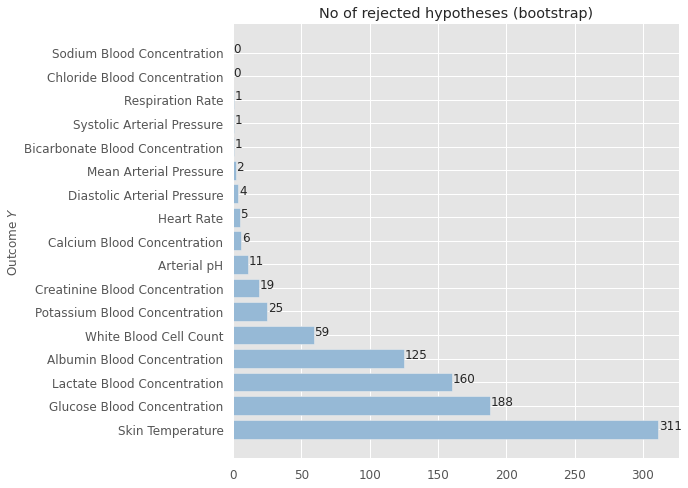

In [119]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

# hyp_test_dir = "/data/localhost/taufiq/hyp-test-dir-biogears/"
hyp_test_dir = "/data/localhost/taufiq/hyp-test-dir-biogears-trajecs/"
rejected_hyp_bootstrap = pd.read_csv(f"{hyp_test_dir}/rej_hyp_nums.csv")
for index, row in rejected_hyp_bootstrap.iterrows():
    rejected_hyp_bootstrap.at[index, 'Outcome Y'] = column_names_dict[row['Outcome Y']]

fig, ax = plt.subplots(figsize=(8,8))

rejected_hyp_bootstrap.sort_values('# rejected hypotheses', ascending=False, inplace=True)
ax.barh(rejected_hyp_bootstrap['Outcome Y'],rejected_hyp_bootstrap['# rejected hypotheses'],  color='#96b9d6')
y = rejected_hyp_bootstrap['# rejected hypotheses']
for i, v in enumerate(y):
    ax.text(v + 0.5, i, str(v), fontsize=12)

plt.title('No of rejected hypotheses (bootstrap)')
plt.ylabel('Outcome $Y$')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.style.use('ggplot')
plt.show()

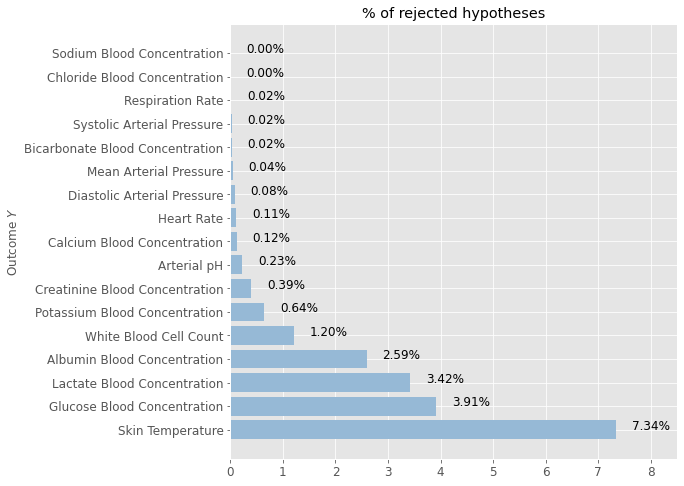

In [22]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

# hyp_test_dir = "/data/localhost/taufiq/hyp-test-dir"

fig, ax = plt.subplots(figsize=(8,8))

rejected_hyp_bootstrap.sort_values('# rejected hypotheses', ascending=False, inplace=True)
ax.barh(rejected_hyp_bootstrap['Outcome Y'],rejected_hyp_bootstrap['# rejected hypotheses']/rejected_hyp_bootstrap['Total # hypotheses']*100,  color='#96b9d6')
y = rejected_hyp_bootstrap['# rejected hypotheses']/rejected_hyp_bootstrap['Total # hypotheses']*100
for i, v in enumerate(y):
    ax.text(v + 0.3, i, "{:.2f}%".format(v), fontsize=12)

plt.title('% of rejected hypotheses')
plt.ylabel('Outcome $Y$')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.style.use('ggplot')
plt.xlim([0,8.5])
plt.show()

In [23]:
rejected_hyp_bootstrap

,Outcome Y,# rejected hypotheses,Total # hypotheses
1,Skin Temperature,311,4235
10,Glucose Blood Concentration,188,4803
3,Lactate Blood Concentration,160,4679
7,Albumin Blood Concentration,125,4818
12,White Blood Cell Count,59,4913
0,Potassium Blood Concentration,25,3907
8,Creatinine Blood Concentration,19,4817
5,Arterial pH,11,4869
11,Calcium Blood Concentration,6,4926
4,Heart Rate,5,4519


In [111]:
col_name = "WBC_count"

rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col_name}.csv", converters={'actions': eval})
trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions_{col_name}.csv", converters={'actions': eval})
sim_trajec_actions = pd.read_csv(f"{hyp_test_dir}/sim_trajec_actions_{col_name}.csv", converters={'actions': eval})

In [112]:
# plot_bounds_bootstrap('Glucose', 1, 4, [1, 1, 1, 1], [4,4,4,4])

In [113]:
def rej_hyps_age_group(col, gender, age):
    state_actions = trajec_actions[['gender', 'age', 'actions', col]].copy()
    state_actions.loc[:,'a'] = state_actions['actions'].apply(tuple)
    state_actions.loc[:,'s'] = state_actions[col].apply(tuple)
    state_actions = state_actions.drop_duplicates(['gender', 'age', 'a', 's'])
    total_hyp = ((state_actions['age']==age)&(state_actions['gender']==gender)).sum()
    rej_hyps_num = ((rej_hyps['age']==age)&(rej_hyps['gender']==gender)).sum()
    return rej_hyps_num/total_hyp*100

In [114]:
rej_hyps_age_group(col_name, 1, 1)

1.1131725417439702

In [115]:
ages = []
for i in range(1, 4):
    age_min = str(int(MIMICtable.loc[MIMICtable['age']==i, 'age_raw'].min()/365))
    age_max = str(int(MIMICtable.loc[MIMICtable['age']==i+1, 'age_raw'].min()/365))
    ages.append(f'{age_min}-{age_max}')
ages.append(f'>{age_max}')

In [116]:
rej_hyps_age = pd.DataFrame()
gend = ['male', 'female']
for gender in [0,1]:
    for age in [1,2,3,4]:
        rh = rej_hyps_age_group(col_name, gender, age)
        rej_hyps_age = rej_hyps_age.append({'gender': gend[gender], 'age': ages[age-1], 'rej_hyps': rh}, ignore_index=True)

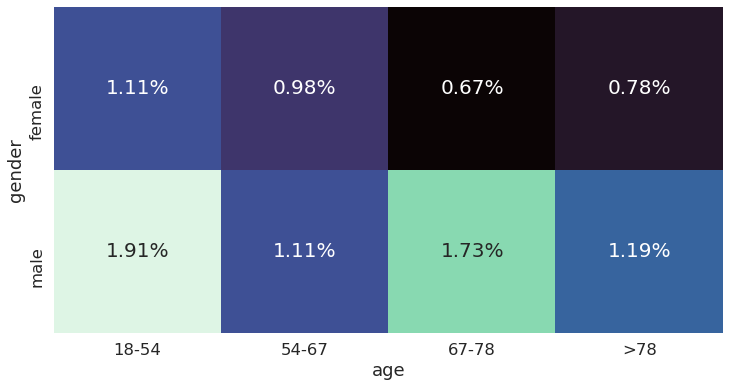

In [117]:
import seaborn as sns
fig, axs = plt.subplots(1, figsize=(12,6))
rej_hyps_age_pivot = rej_hyps_age.pivot_table(index="gender", columns="age", values="rej_hyps", aggfunc=np.min)
sns.set(font_scale=1.5)
labels = np.round(rej_hyps_age_pivot.values,2).astype(str)
for i in range(len(labels)):
    for j in range(len(labels[0])):
        labels[i][j] += '%'
sns.heatmap(rej_hyps_age_pivot, vmax=rej_hyps_age_pivot.values.max(), vmin=rej_hyps_age_pivot.values.min(), annot=labels, fmt='', cmap='mako', ax=axs, annot_kws={"fontsize":20}, cbar=False)